In [1]:
using Plots, Distributions
import SpecialFunctions, TxModels, Random
gr()

┌ Info: Recompiling stale cache file /Users/rowanbrackston/.julia/compiled/v1.1/TxModels.ji for TxModels [top-level]
└ @ Base loading.jl:1184


Plots.GRBackend()

# Extrinsic noise
## Mixing distribution
First try out the effect of different distributions for $K$ 

  0.073829 seconds (618.62 k allocations: 18.780 MiB, 16.78% gc time)
  0.037974 seconds (412.33 k allocations: 11.953 MiB)
  0.019509 seconds (274.89 k allocations: 7.760 MiB)


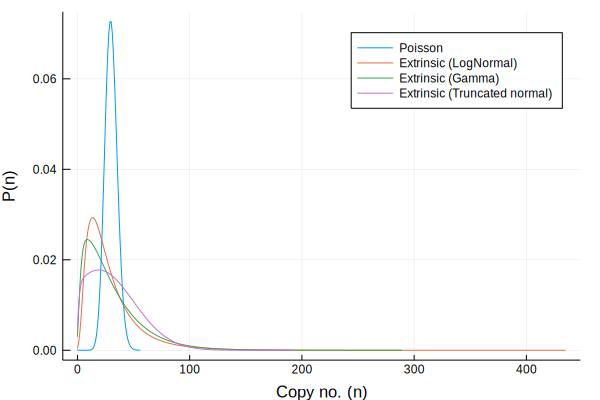

In [134]:
meanParams = [30.,1.,0.]
hyperParams = [25.0] # std deviation of variable parameter
parIndex = [1] # Choose only K variable
P = TxModels.solvemaster(meanParams)
plot(0:length(P)-1, P, label="Poisson", xlabel="Copy no. (n)",ylabel="P(n)")
@time Q = TxModels.solvecompound(meanParams,hyperParams,:LogNormal,parIndex, lTheta=100,cdfMax=0.9999)#,N=Integer(ceil(1.2*maximum(rnaData))))
plot!(0:length(Q)-1, Q, label="Extrinsic (LogNormal)")
@time Q2 = TxModels.solvecompound(meanParams,hyperParams,:Gamma,parIndex, lTheta=100,cdfMax=0.9999)#,N=Integer(ceil(1.2*maximum(rnaData))))
plot!(0:length(Q2)-1, Q2, label="Extrinsic (Gamma)")
@time Q3 = TxModels.solvecompound(meanParams,hyperParams,:Normal,parIndex, lTheta=100,cdfMax=0.9999)#,N=Integer(ceil(1.2*maximum(rnaData))))
plot!(0:length(Q3)-1, Q3, label="Extrinsic (Truncated normal)")

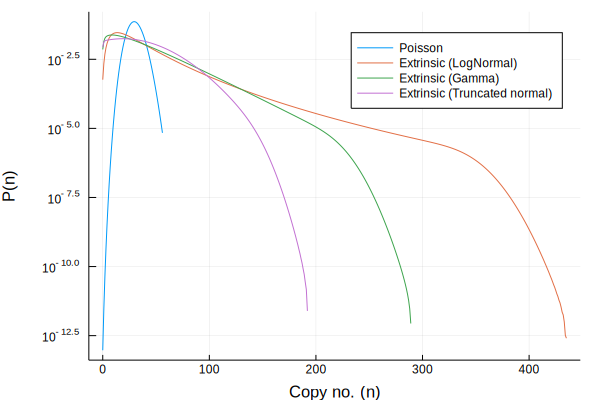

In [111]:
plot!(yscale=:log10)

## Mixing parameter
Examine the effect of having different parameters as variable.

  0.022354 seconds (175.74 k allocations: 5.170 MiB)
  0.028242 seconds (175.00 k allocations: 5.153 MiB)
  0.010328 seconds (124.51 k allocations: 3.328 MiB)


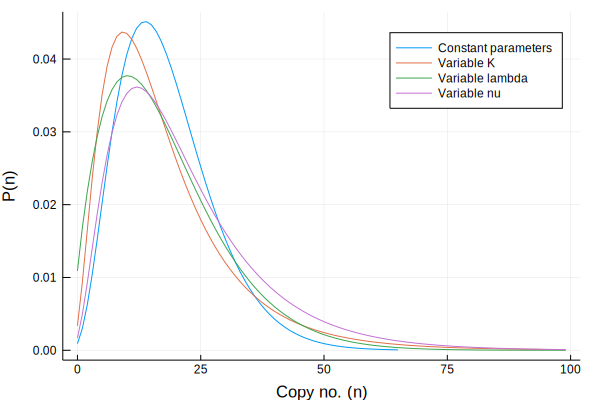

In [135]:
meanParams = [200.,4.0,40.0]
P = TxModels.solvemaster(meanParams)
plot(0:length(P)-1, P, label="Constant parameters", xlabel="Copy no. (n)",ylabel="P(n)")
@time Q = TxModels.solvecompound(meanParams,[100.0],:LogNormal,[1], lTheta=100,cdfMax=0.9999,N=100)
plot!(0:length(Q)-1, Q, label="Variable K")
@time Q2 = TxModels.solvecompound(meanParams,[2.0],:LogNormal,[2], lTheta=100,cdfMax=0.9999,N=100)
plot!(0:length(Q2)-1, Q2, label="Variable lambda")
@time Q3 = TxModels.solvecompound(meanParams,[20.0],:LogNormal,[3], lTheta=100,cdfMax=0.9999,N=100)
plot!(0:length(Q3)-1, Q3, label="Variable nu")

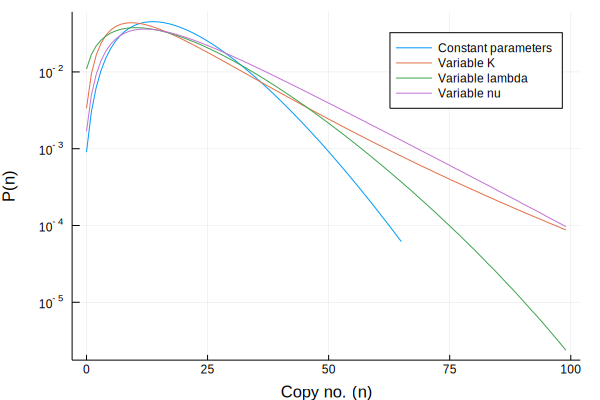

In [136]:
plot!(yscale=:log10)

## Multiple mixing parameters
Evaluate distribution with multiple variable parameters.

*Multiple integrations makes this very slow*

  0.021164 seconds (156.93 k allocations: 4.500 MiB)
243.300048 seconds (1.61 G allocations: 46.010 GiB, 9.18% gc time)


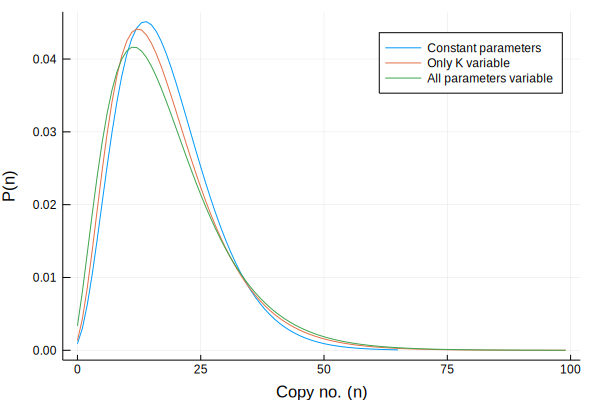

In [140]:
meanParams = [200.,4.0,40.0]
hyperParams = [50.0,1.0,1.0]
P = TxModels.solvemaster(meanParams)
plot(0:length(P)-1, P, label="Constant parameters", xlabel="Copy no. (n)",ylabel="P(n)")
@time Q = TxModels.solvecompound(meanParams,hyperParams[1:1],:LogNormal,[1], lTheta=100,cdfMax=0.9999,N=100)
plot!(0:length(Q)-1, Q, label="Only K variable")
@time Q = TxModels.solvecompound(meanParams,hyperParams,:LogNormal,[1,2,3], lTheta=100,cdfMax=0.9999,N=100)
plot!(0:length(Q)-1, Q, label="All parameters variable")

## Leaky expression model
Compare the distributions from the model with single and dual transcription rates.

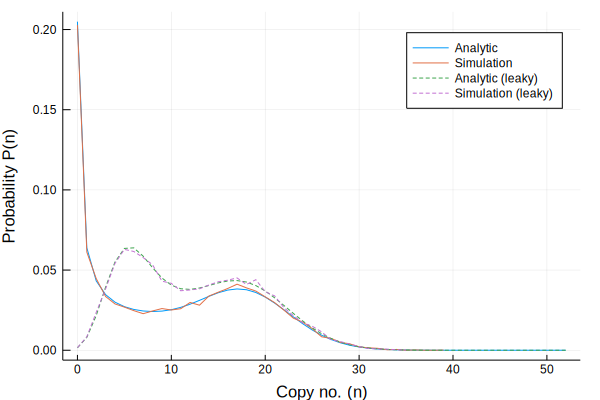

In [28]:
meanParams = [20.,0.3,0.3]
P = TxModels.solvemaster(meanParams)
Nvec,Psim = TxModels.simmaster(meanParams)
plot(0:length(P)-1, P, label="Analytic", xlabel="Copy no. (n)")
plot!(Nvec, Psim, label="Simulation", ylabel="Probability P(n)")

P = TxModels.solvemaster([5.0; meanParams[:]])
Nvec,Psim = TxModels.simmaster([5.0; meanParams[:]])
plot!(0:length(P)-1, P, label="Analytic (leaky)", line=:dash)
plot!(Nvec, Psim, label="Simulation (leaky)", line=:dash)

## Testing Heavy Tailedness

A first challenge is, given a set of samples, to establish whether the data is drawn from a heavy tailed distribution.

First make a bursty transcription model that fits a negative binomial distribution,  and a constitutive model that fits a Poisson.

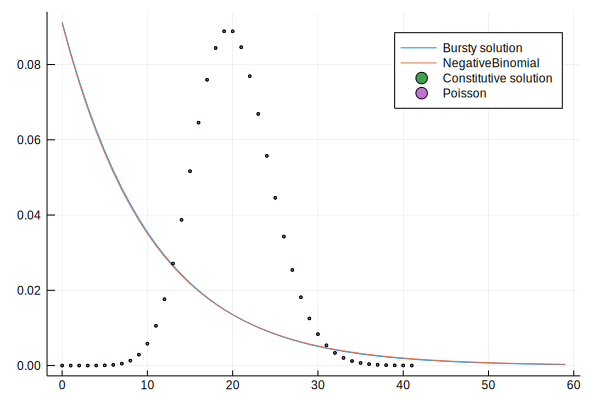

In [3]:
ParamsB = [500, 1.0, 50.0]
P = TxModels.solvemaster(ParamsB, 250)
plot(0:1:length(P)-1, P, label="Bursty solution")
r = ParamsB[2]
p = ParamsB[3]/(ParamsB[1]+ParamsB[3])
dNB = NegativeBinomial(r,p)
plot!(0:1:length(P)-1, x->pdf(dNB,x), label="NegativeBinomial")

ParamsC = [20, 1.0, 0.0]
P = TxModels.solvemaster(ParamsC, 250)
plot!(0:1:length(P)-1, P, label="Constitutive solution", line=0,marker=1)
dataC = TxModels.samplecompound(ParamsC,[0.2*ParamsC[1]],:Poisson,:LogNormal,1000000)
dP = Poisson(ParamsC[1])
plot!(0:1:length(P)-1, x->pdf(dP,x), line=0,marker=1, label="Poisson")

### Empirical pdf
Generate a normalised histogram from a large number of samples.

Implementing integer version of genpdf.
Implementing integer version of genpdf.


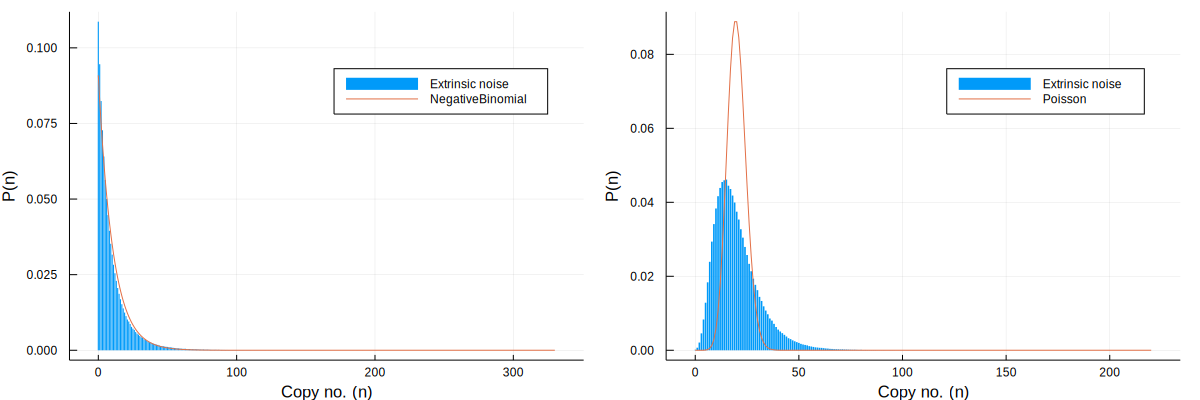

In [21]:
dataB = TxModels.samplecompound(ParamsB,[0.5*ParamsB[1]],:NegativeBinomial,:LogNormal,1000000)
dataC = TxModels.samplecompound(ParamsC,[0.5*ParamsC[1]],:Poisson,:LogNormal,1000000)
plt = plot(plot(),plot(), size=(1200,400))

x,y = TxModels.genpdf(Integer.(dataB))
bar!(plt[1], x,y, line=0, label="Extrinsic noise")
plot!(plt[1], x, x->pdf(dNB,x), label="NegativeBinomial", xlabel="Copy no. (n)",ylabel="P(n)")

x,y = TxModels.genpdf(Integer.(dataC))
bar!(plt[2], x,y, line=0, label="Extrinsic noise")
plot!(plt[2], x, x->pdf(dP,x), label="Poisson", xlabel="Copy no. (n)",ylabel="P(n)")

### Rank ordering
Generate the rank ordering plot as in Sornette *et al.* (1996). Consider only the 100 largest samples.

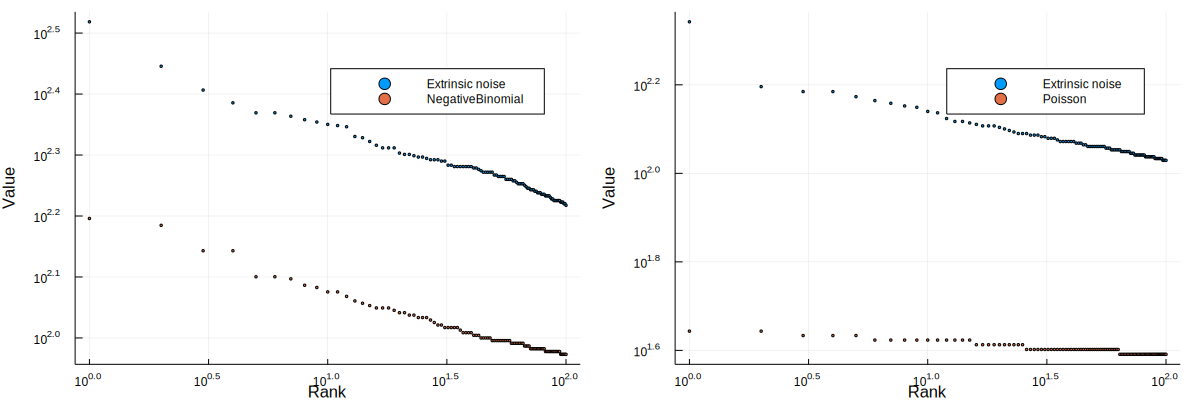

In [22]:
plt = plot(plot(),plot(), size=(1200,400))
Ns = 100

reverse!(sort!(dataB))
plot!(plt[1], 1:Ns,dataB[1:Ns], yscale=:log10,xscale=:log10, line=0,marker=1, label="Extrinsic noise")
dataNB = rand(dNB,1000000)
reverse!(sort!(dataNB))
plot!(plt[1], 1:Ns,dataNB[1:Ns], line=0,marker=1, xlabel="Rank",ylabel="Value",label="NegativeBinomial")

reverse!(sort!(dataC))
plot!(plt[2], 1:Ns,dataC[1:Ns], yscale=:log10,xscale=:log10, line=0,marker=1, label="Extrinsic noise")
dataP = rand(dP,1000000)
reverse!(sort!(dataP))
plot!(plt[2], 1:Ns,dataP[1:Ns], line=0,marker=1, xlabel="Rank",ylabel="Value",label="Poisson")

### Moment convergence
Examine the convergence of the variance, comparing the cases with and without extrinsic noise.

First look at an individual case:

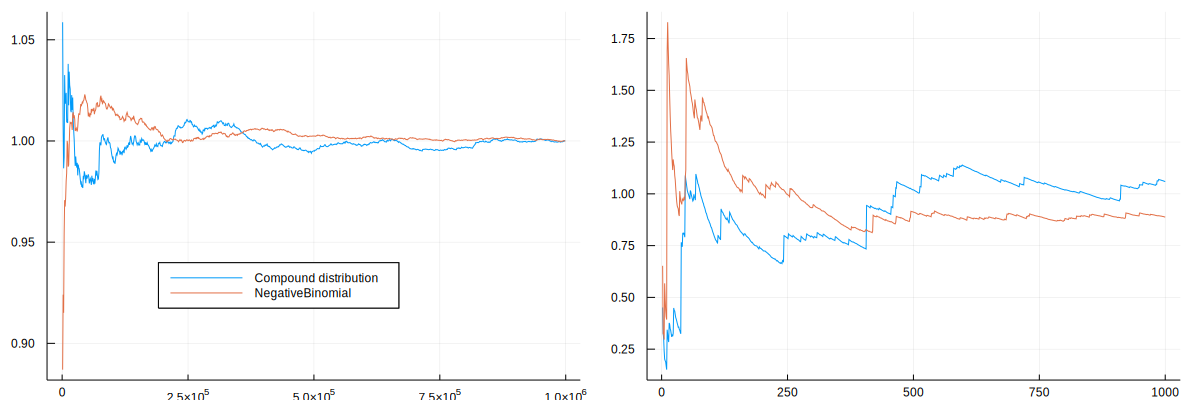

In [23]:
plt = plot(plot(),plot(), size=(1200,400))

v = var(dataB)
Random.shuffle!(dataB)
plot!(plt[1], 1:1000:1000000, x->var(dataB[1:x])/v, label="Compound distribution")
plot!(plt[2], 1:1000, x->var(dataB[1:x])/v, label="Compound distribution")

v = var(dataNB)
Random.shuffle!(dataNB)
plot!(plt[1], 1:1000:1000000, x->var(dataNB[1:x])/v, label="NegativeBinomial", legend=:bottom)
plot!(plt[2], 1:1000, x->var(dataNB[1:x])/v, label="NegativeBinomial", legend=:bottom)

Now look at the average convergence over 1000 cases.

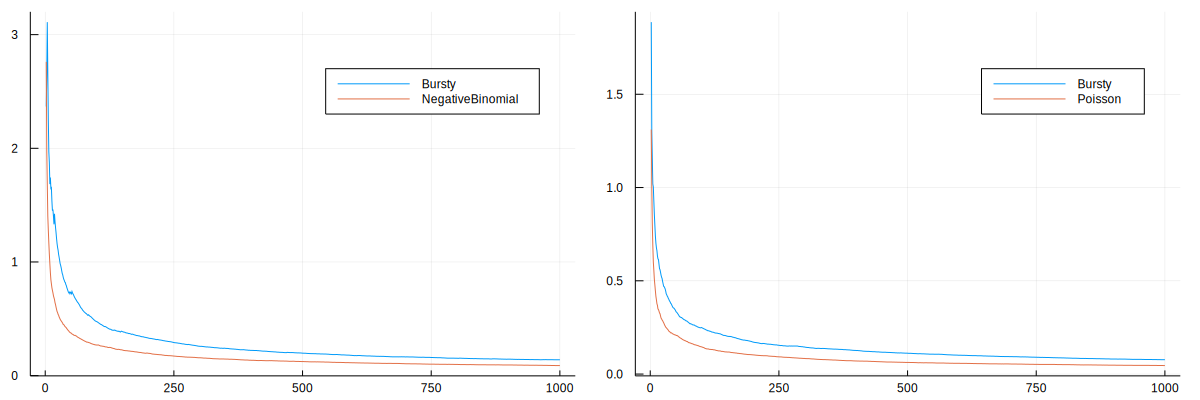

In [29]:
matB = zeros(1000,1000)
matNB = zeros(1000,1000)
matC = zeros(1000,1000)
matP = zeros(1000,1000)

for r=1:1000
    Random.shuffle!(dataB)
    Random.shuffle!(dataNB)
    Random.shuffle!(dataC)
    Random.shuffle!(dataP)
    for ii=1:1000
        matB[r,ii] = var(dataB[1:ii])
        matNB[r,ii] = var(dataNB[1:ii])
        matC[r,ii] = var(dataC[1:ii])
        matP[r,ii] = var(dataP[1:ii])
    end
end
matB = matB./var(dataB)
matNB = matNB./var(dataNB)
matC = matC./var(dataC)
matP = matP./var(dataP)

plt = plot(plot(),plot(), size=(1200,400))
plot!(plt[1], 1:1000, x->std(matB[:,x]), label="Bursty")
plot!(plt[1], 1:1000, x->std(matNB[:,x]), label="NegativeBinomial")
plot!(plt[2], 1:1000, x->std(matC[:,x]), label="Bursty")
plot!(plt[2], 1:1000, x->std(matP[:,x]), label="Poisson")

Finally, to check the theory, compare a LogNormal and a Gamma, each having the same mean and variance as each other. It would appear that despite the LogNormal being technically heavy tailed, the convergence of the variance is almost identical.

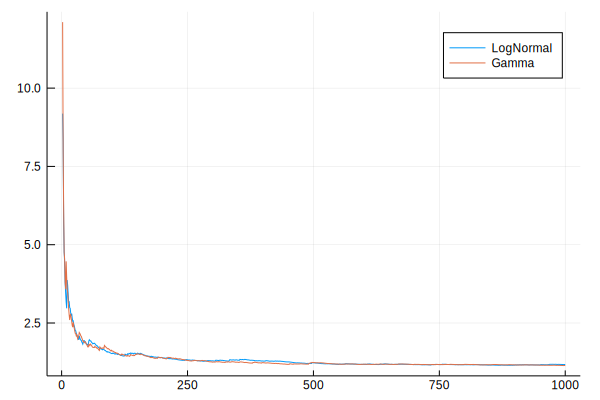

In [27]:
m = 20
v = 6
dL = LogNormal(log(m/sqrt(1+v/m^2)),sqrt(log(1+v/m^2)))
dG = Gamma(m^2/v,v/m)
dataL = rand(dL,1000000)
dataG = rand(dG,1000000)

matL = zeros(1000,1000)
matG = zeros(1000,1000)
for r=1:1000
    Random.shuffle!(dataL)
    Random.shuffle!(dataG)
    for ii=1:1000
        matL[r,ii] = var(dataL[1:ii])
        matG[r,ii] = var(dataG[1:ii])
    end
end
matL = matL./var(dataL)
matG = matG./var(dataG)

plot(1:1000, x->maximum(matL[:,x]), label="LogNormal")
plot!(1:1000, x->maximum(matG[:,x]), label="Gamma")

## Miscellaneous
Verify accuracy of the numerical integration against an analytical solution.
A poor match if *cdfMax* is too small.

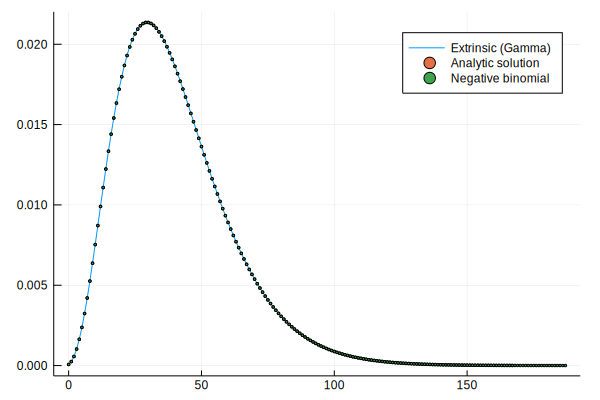

In [132]:
meanParams = [40.,1.,0.]
hyperParams = [20.0] # std deviation of variable parameter
Q = ModelInference.solvecompound(meanParams,hyperParams,:Gamma,[1], lTheta=100,cdfMax=0.999)
plot(0:length(Q)-1, Q, label="Extrinsic (Gamma)")

θ = hyperParams[1]^2/meanParams[1]
k = (meanParams[1]/hyperParams[1])^2

function func(m::Integer,z)
    tmp = 1.0
    for ii=0:m-1
        tmp *= z+ii
    end
    return tmp
end
q(n::Integer) = func(n,k)/(θ^(-n)*factorial(big(n))*(1+θ)^(n+k))
plot!(0:1:length(Q)-1, x->q(x), line=0,marker=1, label="Analytic solution")

d = NegativeBinomial(k,1/(1+θ))
plot!(0:1:length(Q)-1, x->pdf(d,x), line=0,marker=1, label="Negative binomial")
plot!()
